# Recurrent Neural Network

In [1]:
from __future__ import print_function

import torch, matplotlib
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

T = 20
L = 1000
N = 100

In [2]:
x = np.empty((N, L), 'int32')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float32')

# load data and make training set
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])

test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])

In [3]:
class Sequence(nn.Module):
    """
    Fully-connected model, with one hidden layer.
    
    Attributes
    ----------
    rnn : torch.nn.modules.linear.RNNCell
        The recurrent layer.
    linear : torch.nn.modules.linear.Linear
        The fully connected layer.
    hdim : int
        The dimension of the space.
    
    Examples
    --------
    >>> seq = Sequence(10)
    >>> criterion = nn.MSELoss()
    >>> optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
    """
    
    def __init__(self, hdim):
        """
        Creation of the model.
        """
        super(Sequence, self).__init__()
        self.rnn = nn.RNNCell(1, hdim)
        self.linear = nn.Linear(hdim, 1)
        self.hdim = hdim

    def forward(self, input, future = 0):
        """
        A forward pass in the model.
        
        Parameters
        ----------
        input : torch.nn_like
            The input of the model.
        future : int, default: 0
            The time of prediction.
        
        Returns
        -------
        out : torch.nn_like
            The output of the model.
        
        Notes
        -----
        This function as not to be call directly.
        """
        outputs = []
        
        # create a tensor for the hidden state initialized to zero
        h_t = torch.zeros(input.size(0), self.hdim, dtype=torch.float)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            # apply the RNN
            h_t = self.rnn(input_t, h_t)
            # apply the linear layer 
            output = self.linear(h_t)
            outputs.append(output)
        
        for i in range(future): # if we should predict the future
            # apply the RNN to the last value
            h_t = self.rnn(output, h_t)
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [4]:
# build the model with 10 hidden units
seq = Sequence(10)

criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

STEP: 0 loss: 0.00036276283208280845 test loss: 0.0003916593559551984


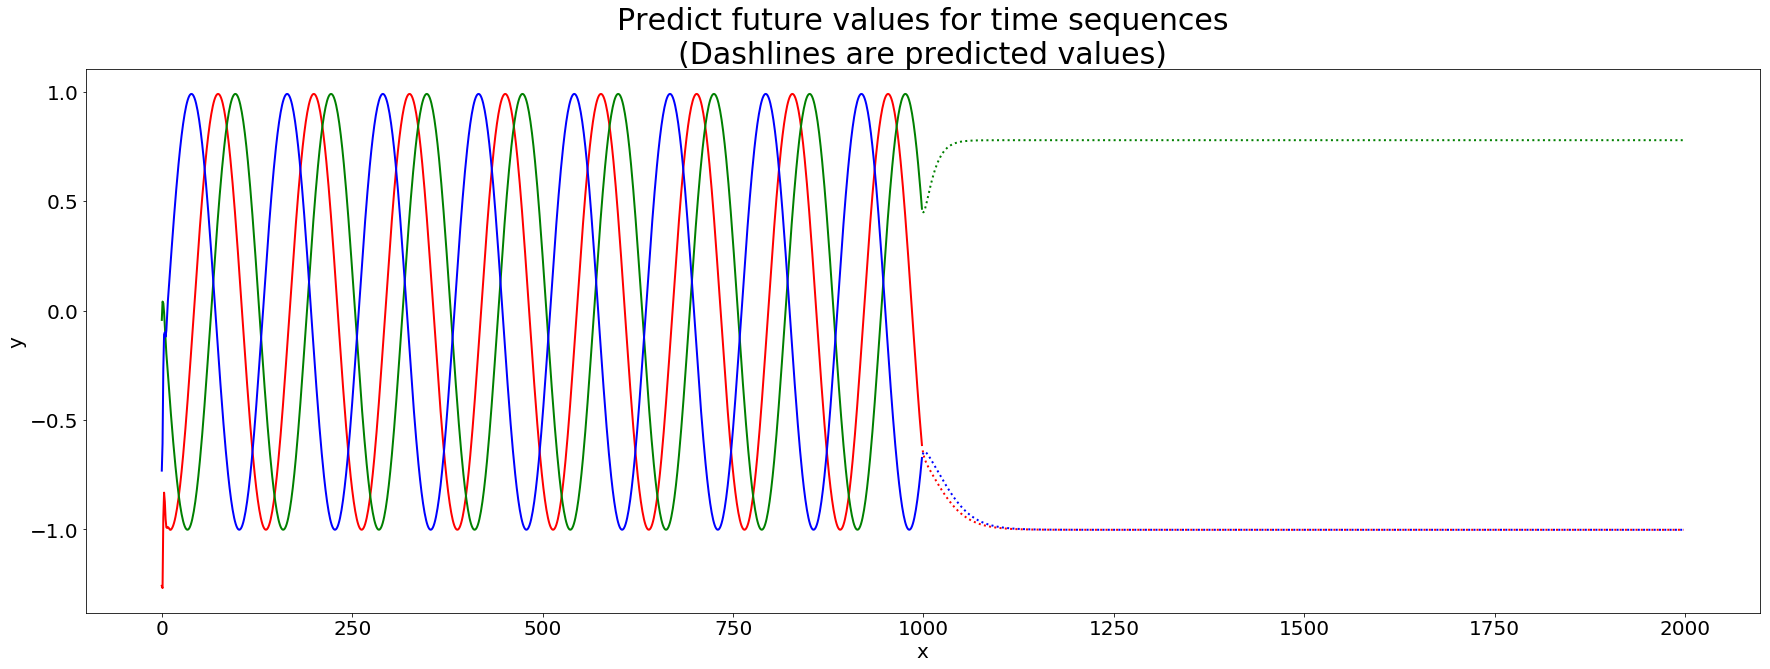

STEP: 1 loss: 0.00015759377856738865 test loss: 0.0001234074734384194


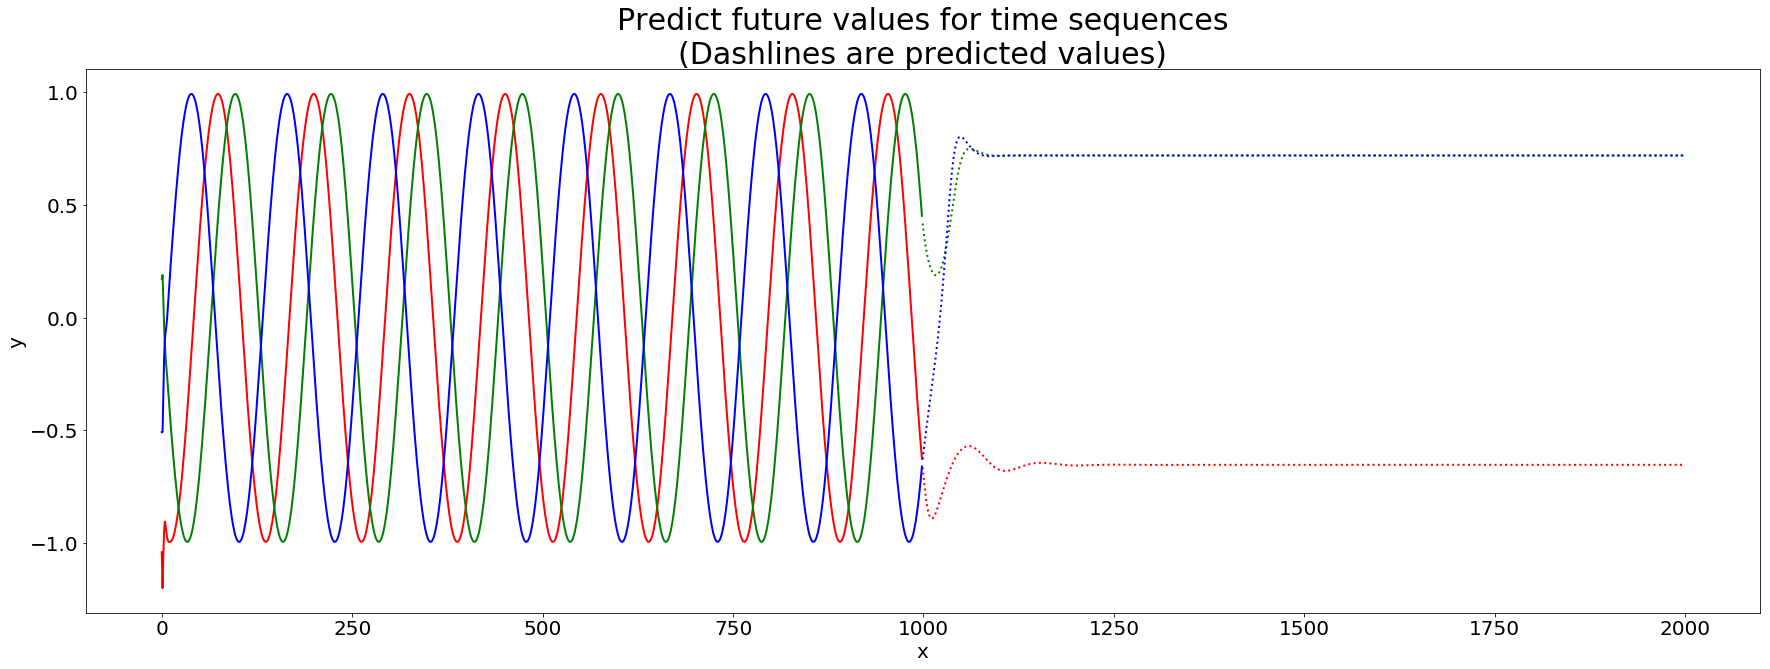

STEP: 2 loss: 0.00010612916230456904 test loss: 8.664488268550485e-05


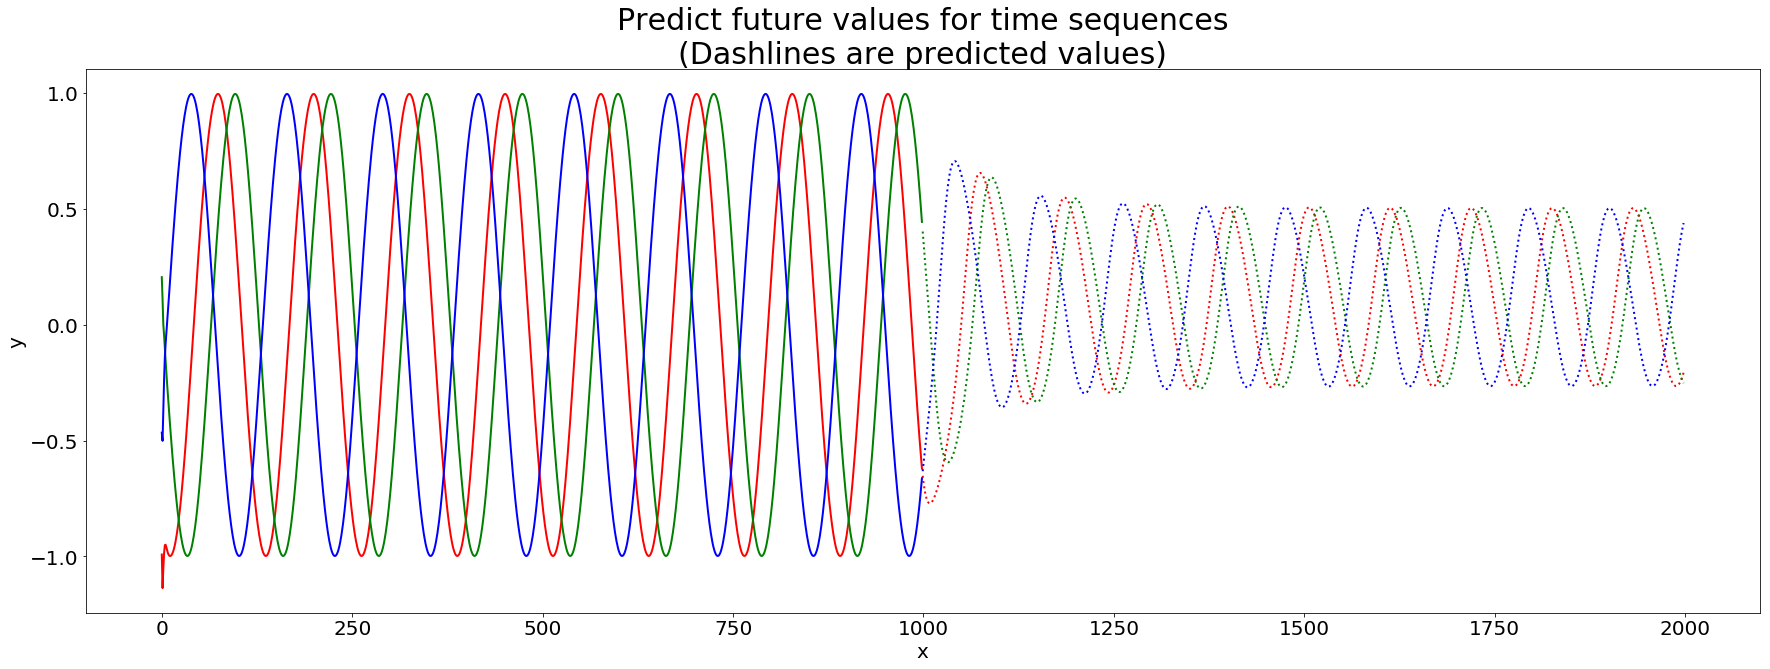

STEP: 3 loss: 8.478055679006502e-053 test loss: 7.826401269994676e-05


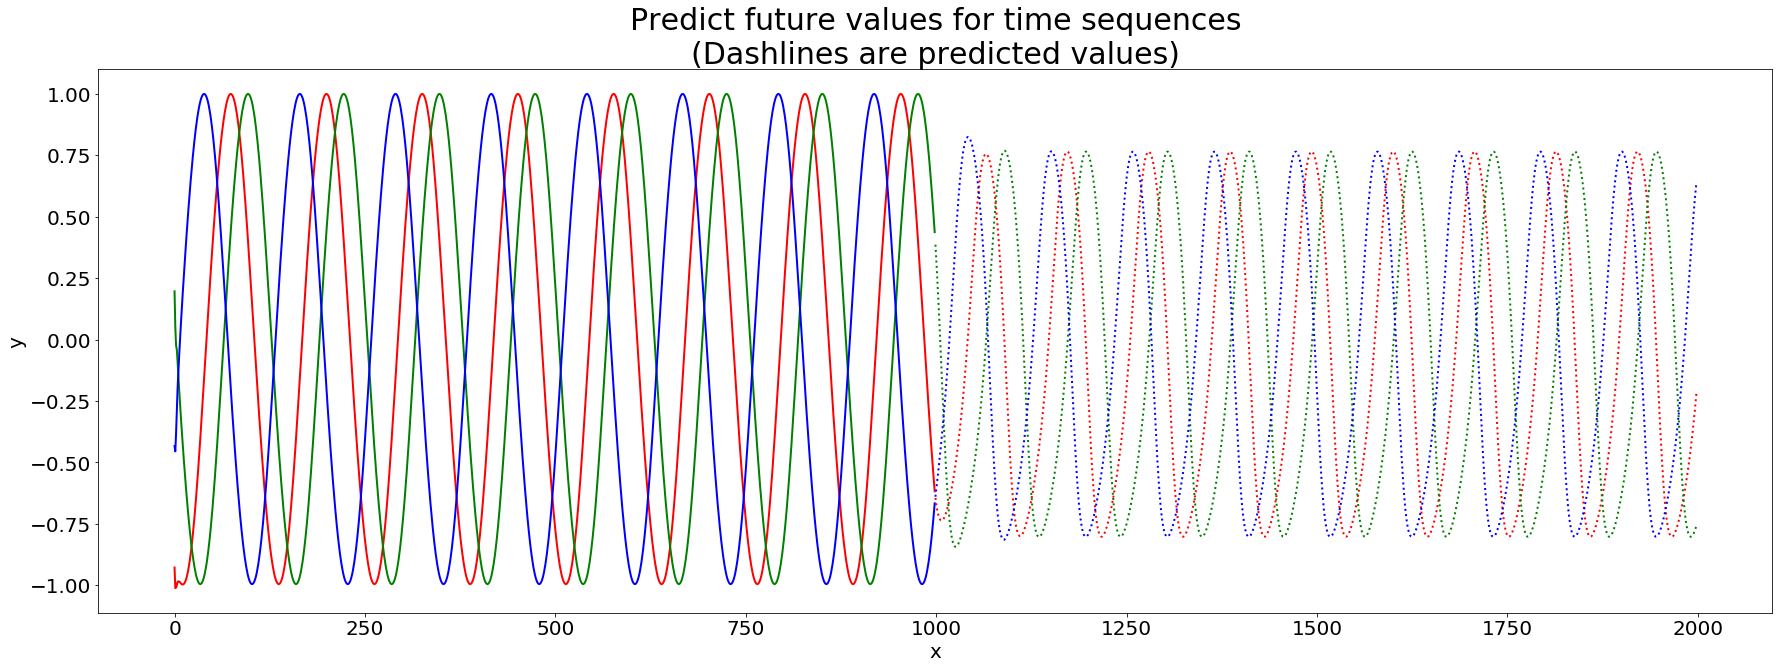

STEP: 4 loss: 6.880453292978927e-05 test loss: 4.5430475438479334e-05


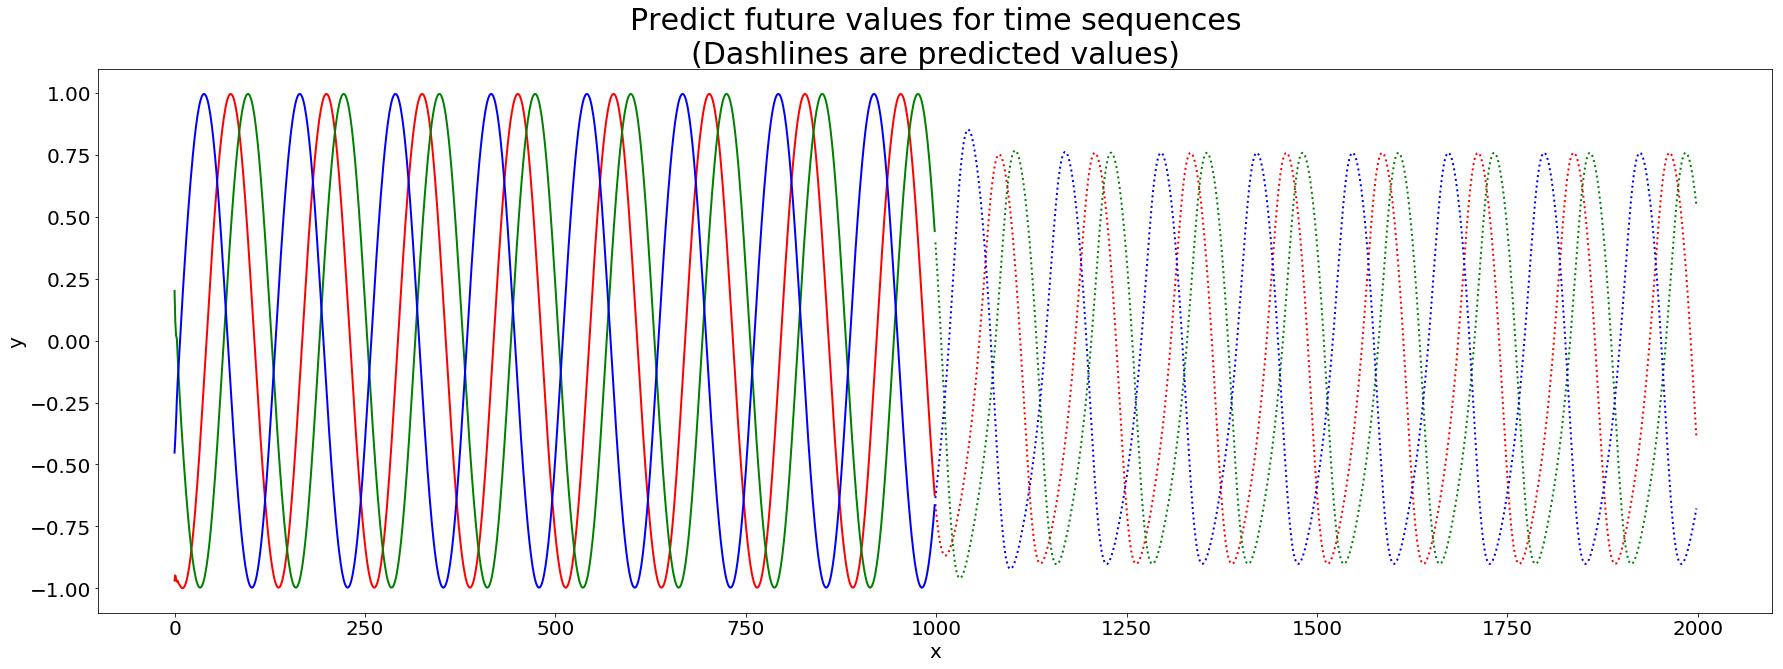

STEP: 5 loss: 0.01177009753882885055 test loss: 5.166011760593392e-05


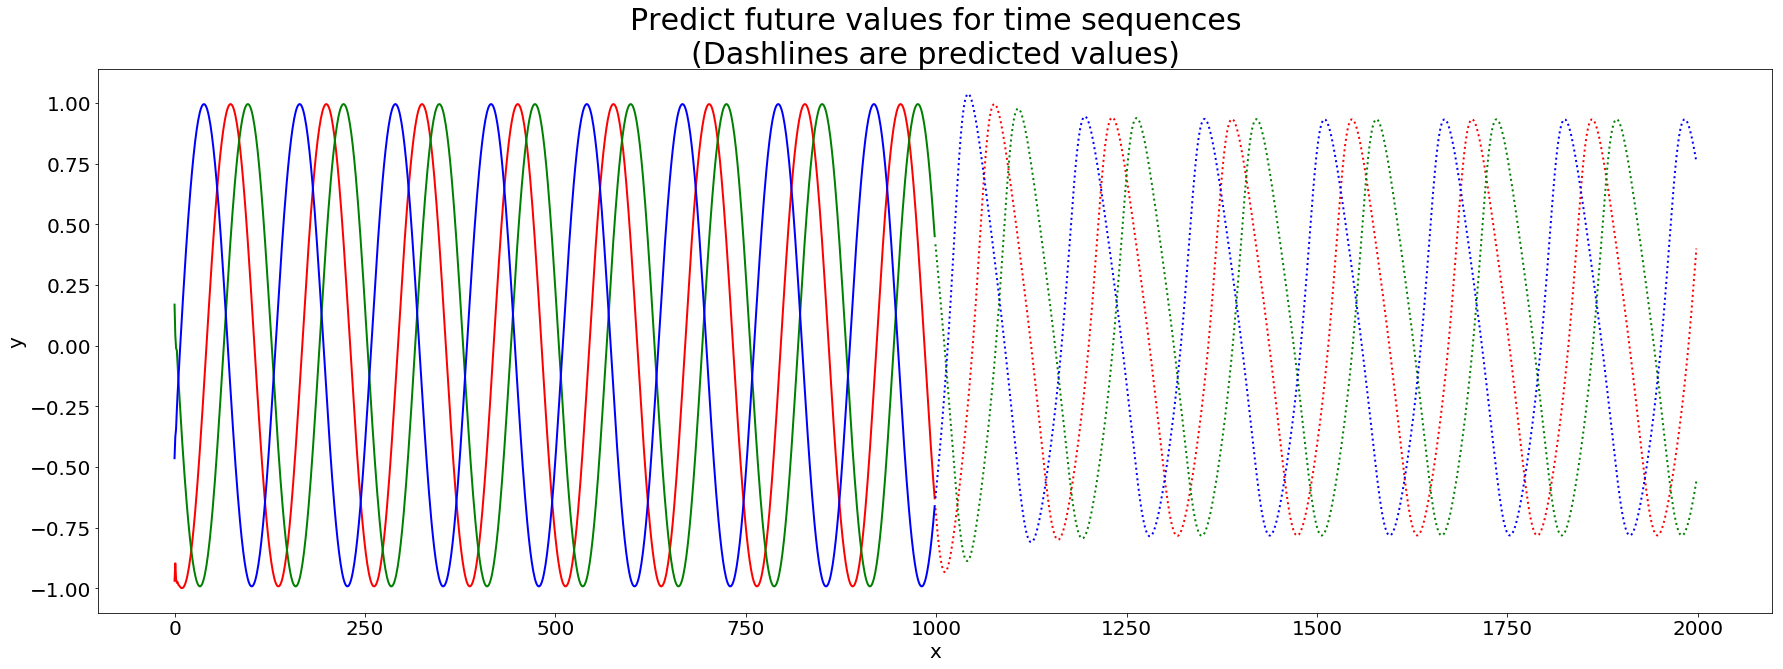

STEP: 6 loss: 4.5233908167574555e-05 test loss: 3.820672645815648e-05


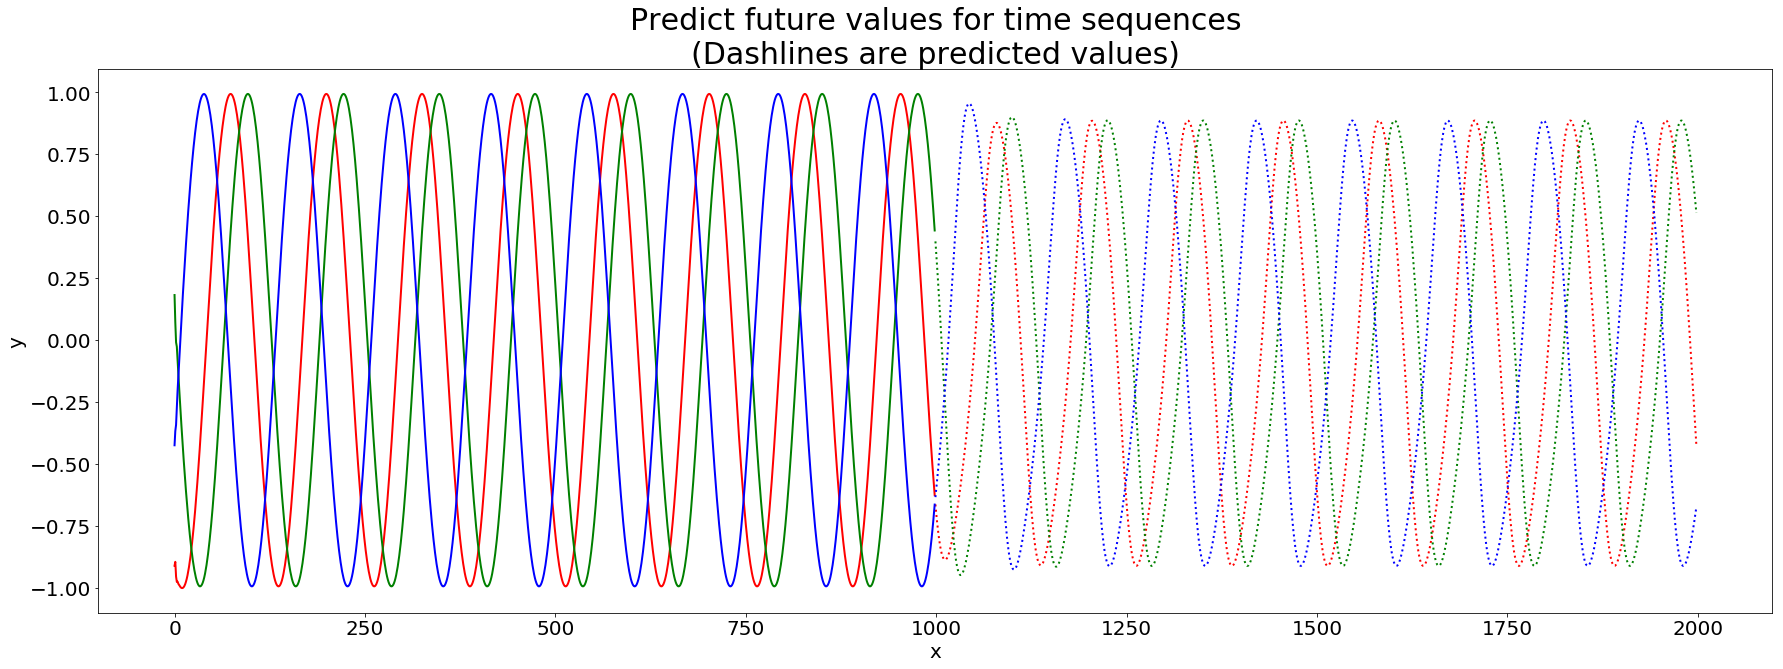

STEP: 7 loss: 2.711454544623848e-055 test loss: 2.6803081709658727e-05


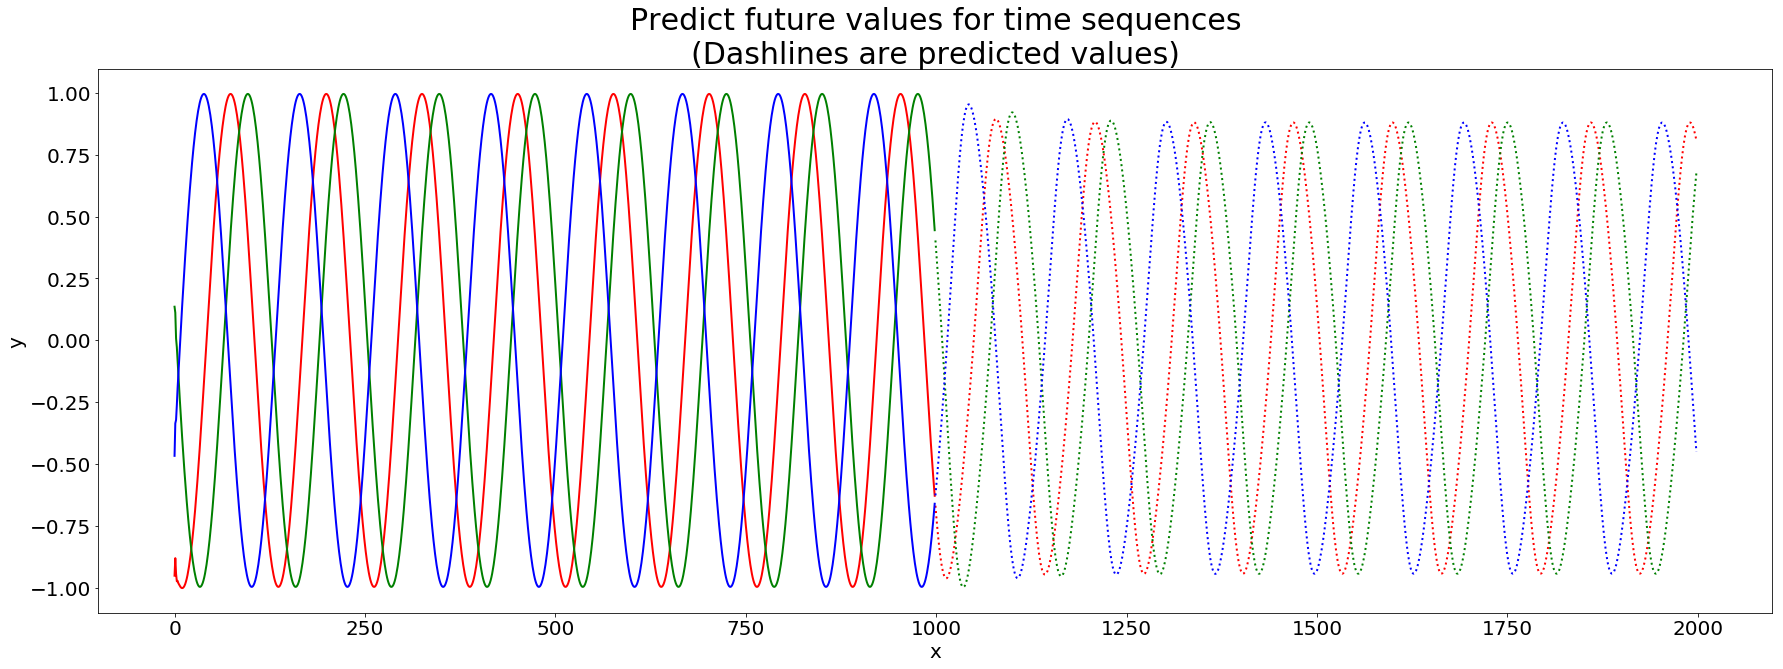

STEP: 8 loss: 2.5613124307710677e-05 loss: 2.556878280302044e-05 test loss: 2.435914211673662e-05


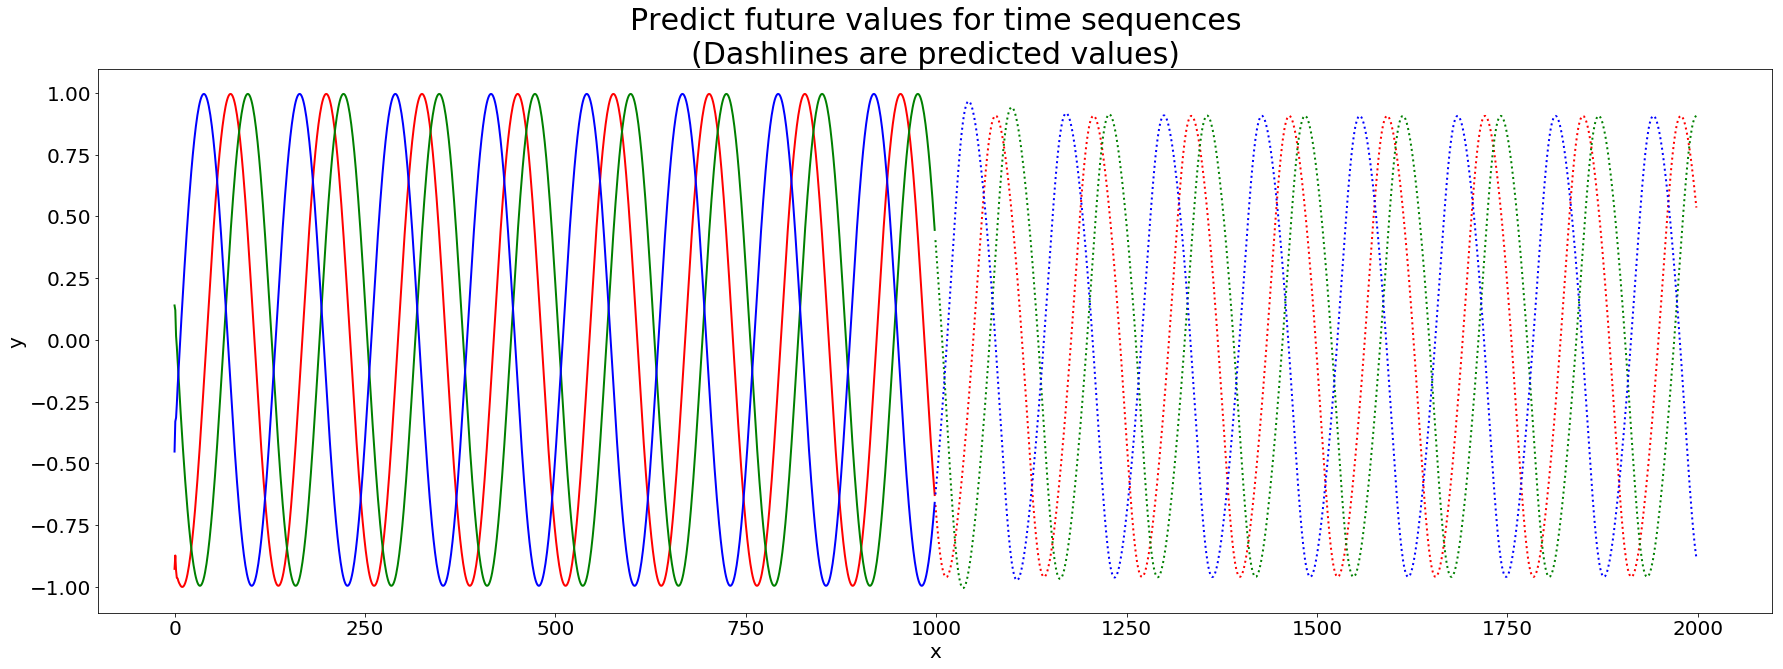

STEP: 9 loss: 2.3561517082271166e-05 test loss: 2.568260060797911e-05


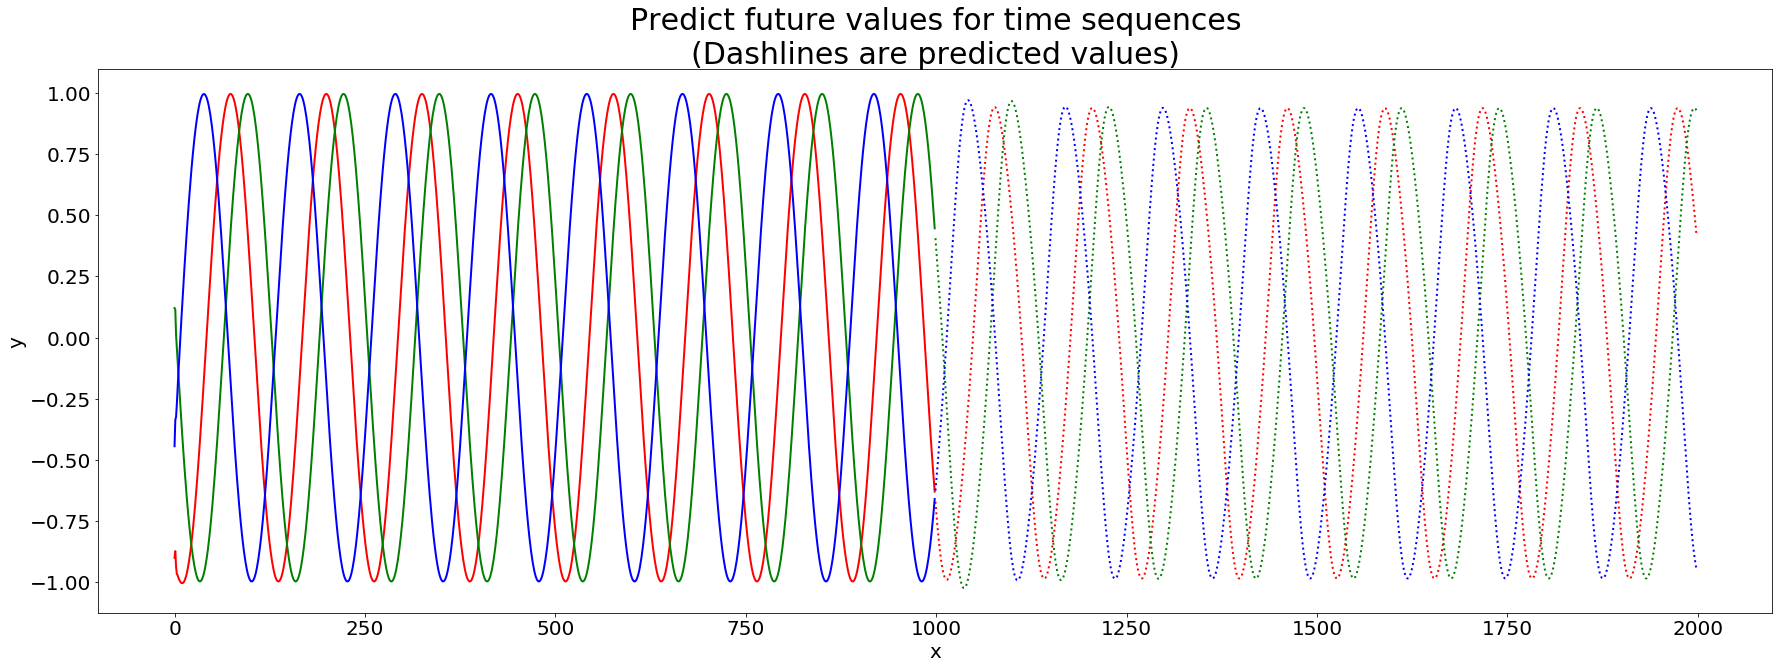

In [5]:
#begin to train
for i in range(10):
    
    def closure():
        """
        The argument of a step of the optimizer.
        
        Returns
        -------
        out : torch.nn.MSELoss
            The loss of the model in the current state.
        """
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('\rSTEP:', i,'loss:', loss.item(), end='')
        loss.backward()
        return loss
    
    optimizer.step(closure)
    
    future = 1000
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print(' test loss:', loss.item())
        y = pred.detach().numpy()
    
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    def draw(yi, color):
        """
        Plot the curve of yi.
        
        Parameters
        ----------
        yi : np.array_like
            The values of the points to plot.
        color : str
            The color of the curve.
        """
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.show()
    #plt.close()